In [1]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [2]:
ibov_close = pd.read_csv(r'C:\Users\loren\Documents\Programação\Github\quantamental-Dev_Wizards\data\ativos_ibov\ivob_close.csv')

threshold = len(ibov_close)
ibov_close.dropna(thresh=threshold, axis=1, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])

ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2014-01-01':'2020-12-31']
returns = ibov_close.pct_change().dropna()

In [3]:
# Portfolio simples com rp
port = rp.Portfolio(returns=returns)

method_mu = 'hist'    # Method to estimate expected returns based on historical data.
method_cov = 'hist'   # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:
model = 'Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'             # Risk measure used, this time will be variance
obj = 'Sharpe'        # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True           # Use historical scenarios for risk measures that depend on scenarios
rf = 0                # Risk free rate
l = 0                 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
weights,1.215601e-10,1.455074e-10,0.099195,1.089727e-10,1.572997e-10,1.308348e-10,3.540379e-10,2.238431e-10,1.121586e-10,1.523509e-10,...,7.209033e-11,2.378126e-10,1.066225e-10,1.062223e-10,1.703933e-10,0.521435,9.555132e-11,4.299946e-10,2.725194e-09,0.351327


In [4]:
N = returns.index
M = returns.columns

In [5]:
def random_array():
    # Choose a random number of ones from a uniform distribution between 50 and 500
    num_ones = np.random.randint(50, 501)
    
    # Generate a binary array with the chosen number of ones placed randomly
    binary_array = np.zeros(len(N) - len(M))
    binary_array[:num_ones] = 1
    np.random.shuffle(binary_array) # Nx1 array
    binary_array = np.insert(binary_array, list(range(len(M))), np.zeros(len(M)))

    return binary_array

In [6]:
def df_weights(returns, binary_array):
    weights_df = pd.DataFrame(columns=M) # 0xM matrix to store the weights 

    # Loop through each date and calculate the weights if the binary array value is 1
    for date in N[binary_array == 1]:
        returns_up_to_date = returns.loc[:date].replace([np.inf, -np.inf], np.nan).dropna()  # Get the data up to the current date and drop rows with NaNs
        
        port = rp.Portfolio(returns=returns_up_to_date) 
        port.assets_stats(method_mu=method_mu, method_cov=method_cov)

        weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        weights_df.loc[date] = weights.T.values[0] # from 0xM to 150xM matrix - store the weights for the current date

    weights_df = weights_df.reindex(returns.index, method='ffill') # frontfill from 150xM to NxM matrix with NaN starting values

    # Fill the starting rows that have NaN values with equally distributed weights
    initial_weights = np.full(len(M), 1 / len(M))
    weights_df.iloc[:np.where(weights_df.notna().any(axis=1))[0][0]] = initial_weights
    weights_df.insert(0, 'rebalancing', binary_array)

    return weights_df

In [7]:
def random_rebalances_portfolio(returns, weights_df_random):
    portfolio_returns = (returns * weights_df_random.drop('rebalancing', axis=1)) # NxN vextor - calculate the portfolio returns

    normalized_portfolio_returns = (1 + portfolio_returns.sum(axis=1)).cumprod()
    
    return normalized_portfolio_returns

In [8]:
# teste para um porfólio
binary_array = random_array()
weights_df_random = df_weights(returns, binary_array)
normalized_portfolio_returns_random = random_rebalances_portfolio(returns, weights_df_random)

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


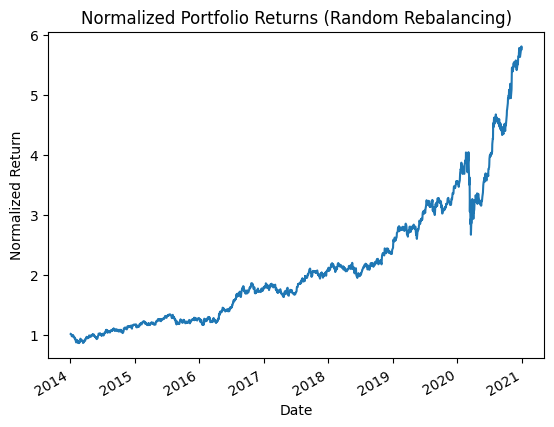

In [9]:
# Plot do um portfólio
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [10]:
def simulate_portfolio():
    binary_array = random_array()
    weights_df_random = df_weights(returns, binary_array)
    normalized_portfolio_returns_random = random_rebalances_portfolio(returns, weights_df_random)
    
    cumulated_return = normalized_portfolio_returns_random.iloc[-1]
    return cumulated_return, binary_array, normalized_portfolio_returns_random

In [11]:
from joblib import Parallel, delayed

num_simulations = 50
simulated_portfolios = []
binarray_cumret_dict = {}

# Paralelizando a simulação
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio)() for _ in range(num_simulations))

# Separando os resultados
for cumulated_return, binary_array, normalized_portfolio_returns_random in results:
    simulated_portfolios.append(normalized_portfolio_returns_random)
    binarray_cumret_dict[cumulated_return] = binary_array

# Convertendo para DataFrame
simulated_portfolios_df = pd.DataFrame(simulated_portfolios).T

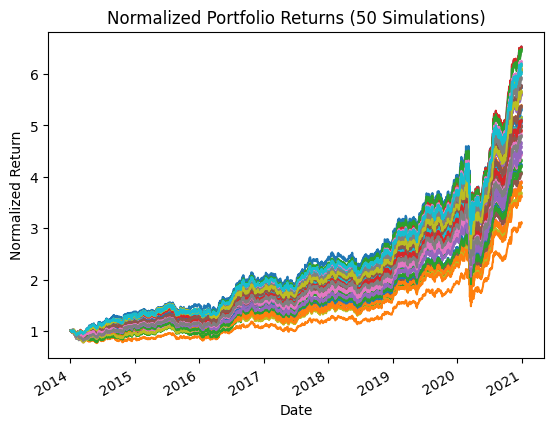

In [12]:
# Plot the results of the simulations
simulated_portfolios_df.plot(title=f'Normalized Portfolio Returns ({num_simulations} Simulations)', legend=False)
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [13]:
binarray_cumret_dict = dict(sorted(binarray_cumret_dict.items(), reverse=True))
binarray_cumret_dict

{6.484361821307958: array([0., 1., 0., ..., 1., 0., 0.]),
 6.481035888007978: array([0., 0., 0., ..., 0., 0., 0.]),
 6.435319081682893: array([0., 0., 0., ..., 0., 1., 0.]),
 6.206995654506875: array([0., 0., 0., ..., 0., 1., 0.]),
 6.157118254348031: array([0., 0., 0., ..., 0., 0., 0.]),
 6.142885906173886: array([0., 0., 0., ..., 0., 1., 1.]),
 6.062756563116827: array([0., 0., 0., ..., 0., 0., 0.]),
 6.048602583194154: array([0., 0., 0., ..., 0., 1., 0.]),
 6.038147403799071: array([0., 0., 0., ..., 0., 0., 0.]),
 6.0004781310209605: array([0., 1., 0., ..., 1., 0., 0.]),
 5.892207271873948: array([0., 0., 0., ..., 0., 0., 0.]),
 5.742744039369228: array([0., 0., 0., ..., 0., 0., 0.]),
 5.740503887278498: array([0., 0., 0., ..., 0., 1., 0.]),
 5.726597662618105: array([0., 1., 0., ..., 0., 0., 1.]),
 5.633531463935494: array([0., 0., 0., ..., 0., 0., 0.]),
 5.605640026060591: array([0., 0., 0., ..., 0., 1., 0.]),
 5.581987991374686: array([0., 1., 0., ..., 0., 0., 0.]),
 5.3558320305

In [14]:
# Quantidade de rebalanceamentos dos melhores portfólios
quantity = 10
top_arrays = list(binarray_cumret_dict.values())[:quantity]
ones_count = [np.sum(array) for array in top_arrays]
print(ones_count)
print(np.mean(ones_count))

[476.0, 403.0, 500.0, 465.0, 344.0, 420.0, 396.0, 457.0, 437.0, 286.0]
418.4


# Penalização
#### IMPORTANTE: a princípio, mais rebalanceamentos dão melhores resultados, mas o retorno real dos portfólios precisam considerar **custo de rebalanceamento** -- existe um viés de quantidade de rebalanceamentos que é diferente de obter apenas os >momentos< bons de reb. -- como eliminar ou diminuir esse viés? 

In [17]:
def penalized_portfolio(returns, weights_df_random, trans_cost_rate=0.01, tax_rate=0.15):
    penalized_returns = returns.copy()  # Copiar os retornos para aplicar penalizações
    accumulated_return = (1 + penalized_returns).cumprod()  # Retorno acumulado até o momento
    
    for i in range(1, len(weights_df_random)):  # Começa em 1 para poder comparar com a linha anterior
        current_weights = weights_df_random.iloc[i].drop('rebalancing')  # Pesos atuais
        previous_weights = weights_df_random.iloc[i - 1].drop('rebalancing')  # Pesos anteriores
        
        # Identificar as colunas (ações) onde o peso atual é menor que o peso anterior (vendas)
        reduced_weight_cols = current_weights.index[current_weights < previous_weights]
        
        for col in reduced_weight_cols:
            weight_diff = previous_weights[col] - current_weights[col]  # Diferença de pesos (parte vendida)
            
            # Aplicar custo de transação: proporcional ao valor vendido
            transaction_cost = trans_cost_rate * weight_diff * returns.iloc[i, returns.columns.get_loc(col)]
            
            # Aplicar imposto sobre ganhos de capital se houver lucro na venda
            if returns.iloc[i, returns.columns.get_loc(col)] > 0:  # Apenas se houve lucro
                capital_gain_tax = tax_rate * weight_diff * returns.iloc[i, returns.columns.get_loc(col)]
            else:
                capital_gain_tax = 0
            
            # Ajustar o retorno penalizado subtraindo os custos e impostos
            penalized_returns.iloc[i, returns.columns.get_loc(col)] -= (transaction_cost + capital_gain_tax)

    # Calcular os retornos do portfólio ajustado com penalizações
    portfolio_returns = (penalized_returns * weights_df_random.drop('rebalancing', axis=1))

    # Normalizar os retornos para obter o retorno acumulado
    normalized_portfolio_returns = (1 + portfolio_returns.sum(axis=1)).cumprod()

    return normalized_portfolio_returns

In [18]:
def simulate_penalized_portfolio():
    binary_array = random_array()
    weights_df_random = df_weights(returns, binary_array)
    normalized_portfolio_returns_random = penalized_portfolio(returns, weights_df_random)
    
    cumulated_return = normalized_portfolio_returns_random.iloc[-1]
    return cumulated_return, binary_array, normalized_portfolio_returns_random

In [19]:
# teste para um porfólio
binary_array = random_array()
weights_df_random = df_weights(returns, binary_array)
normalized_portfolio_returns_random = penalized_portfolio(returns, weights_df_random)

C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


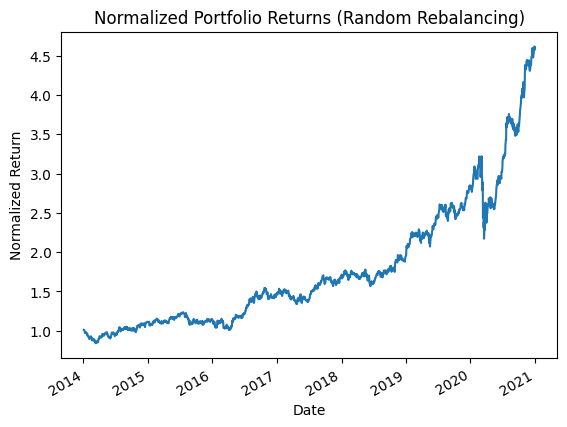

In [20]:
# Plot do um portfólio
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [21]:
num_simulations = 50
simulated_portfolios = []
binarray_cumret_dict = {}

# Paralelizando a simulação
results = Parallel(n_jobs=-1)(delayed(simulate_penalized_portfolio)() for _ in range(num_simulations))

# Separando os resultados
for cumulated_return, binary_array, normalized_portfolio_returns_random in results:
    simulated_portfolios.append(normalized_portfolio_returns_random)
    binarray_cumret_dict[cumulated_return] = binary_array

# Convertendo para DataFrame
simulated_portfolios_df = pd.DataFrame(simulated_portfolios).T

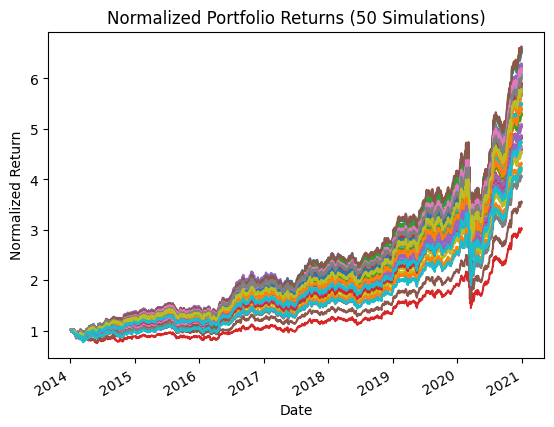

In [22]:
# Plot the results of the simulations
simulated_portfolios_df.plot(title=f'Normalized Portfolio Returns ({num_simulations} Simulations)', legend=False)
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [23]:
binarray_cumret_dict = dict(sorted(binarray_cumret_dict.items(), reverse=True))
binarray_cumret_dict

{6.581645430321507: array([0., 0., 0., ..., 0., 0., 0.]),
 6.5424937833296894: array([0., 0., 0., ..., 0., 0., 0.]),
 6.5256257780065745: array([0., 1., 0., ..., 0., 0., 0.]),
 6.4929385111924525: array([0., 1., 0., ..., 0., 0., 0.]),
 6.247849062487844: array([0., 0., 0., ..., 0., 0., 0.]),
 6.2362367468450985: array([0., 0., 0., ..., 1., 0., 1.]),
 6.220594652432309: array([0., 0., 0., ..., 1., 0., 0.]),
 6.152738854249952: array([0., 1., 0., ..., 0., 0., 1.]),
 6.12689542740881: array([0., 0., 0., ..., 1., 1., 1.]),
 6.04868121716995: array([0., 0., 0., ..., 0., 0., 0.]),
 6.0245406643070245: array([0., 0., 0., ..., 0., 0., 0.]),
 5.973402632740017: array([0., 0., 0., ..., 0., 0., 0.]),
 5.877315116080688: array([0., 0., 0., ..., 0., 0., 1.]),
 5.8506931302359675: array([0., 0., 0., ..., 1., 0., 0.]),
 5.782790000484712: array([0., 0., 0., ..., 0., 1., 0.]),
 5.764096382031539: array([0., 0., 0., ..., 1., 1., 0.]),
 5.760888853189676: array([0., 0., 0., ..., 1., 0., 0.]),
 5.7557970

In [24]:
# Quantidade de rebalanceamentos dos melhores portfólios
quantity = 10
top_arrays = list(binarray_cumret_dict.values())[:quantity]
ones_count = [np.sum(array) for array in top_arrays]
print(ones_count)
print(np.mean(ones_count))

[491.0, 441.0, 488.0, 404.0, 454.0, 398.0, 471.0, 481.0, 368.0, 421.0]
441.7
